# Extra: Model training on partially paired data

In cases where we have paired multi-omics profiles for a subset of cells, such pairing information can also be utilized to improve integration accuracy. Below we will show how to instruct GLUE to utilize paired cells.

In [1]:
from itertools import chain
from random import Random

import anndata as ad
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns
from matplotlib import rcParams

In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

## Read preprocessed data

First, read the preprocessed data as produced by [stage 1](preprocessing.ipynb).

In [3]:
rna = ad.read_h5ad("rna-pp.h5ad")
atac = ad.read_h5ad("atac-pp.h5ad")
guidance = nx.read_graphml("guidance.graphml.gz")

## Label paired cells via `obs_names`

In `scglue`, we use [obs_names](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.obs_names.html#anndata.AnnData.obs_names) of the AnnData objects to identify paired cells across different modalities. Specifically, cells in different modalities with identical `obs_name`s are treated as paired, while cells with different `obs_name`s are treated as unpaired.

The dataset we are using is generated by SNARE-seq, which produces paired scRNA-seq and scATAC-seq profiles. In previous tutorials, we intentionally anonymized the paired cells by appending modality name to the cell barcodes ("\_RNA", "\_ATAC") to mimic an unpaired dataset:

In [4]:
rna.obs_names, atac.obs_names

(Index(['09L_GTTAGAACAGAT_RNA', '09I_CATAGCTCAACG_RNA', '09G_TTACAGGCAGGT_RNA',
        '09B_CTATGGGCGTGC_RNA', '09L_AGTGATTGTTCG_RNA', '09C_ATATGTCTATAA_RNA',
        '09A_CCTATTATTCGA_RNA', '09C_GCGTGCCGAATG_RNA', '09G_AGCTGACGCCGA_RNA',
        '09D_CAGTCCCCAAAT_RNA',
        ...
        '09H_GTTCGCTTGTCG_RNA', '09B_CAGGTGGTCTAT_RNA', '09C_GACCCTGTCGTT_RNA',
        '09I_AACCAATCCTCA_RNA', '09C_AGAGTCTGAAAC_RNA', '09E_CCTGCTCGTCAC_RNA',
        '09E_TGAGCACCTCCT_RNA', '09E_CCGGACTCGATC_RNA', '09F_GCCCGACTCGCA_RNA',
        '09D_ATACTGCGCCCA_RNA'],
       dtype='object', name='cells', length=9190),
 Index(['09L_GTAAACCCGATA_ATAC', '09D_GCCGGGCGGCCG_ATAC',
        '09J_TAGGCCTGAATT_ATAC', '09C_TCCGGCATCTCA_ATAC',
        '09C_AGGCCACGTACA_ATAC', '09E_AAGGGGAGCTGG_ATAC',
        '09K_CCGCCTTATAAT_ATAC', '09A_CGGATGTATCAT_ATAC',
        '09B_TCAGAACTGCTA_ATAC', '09J_TCCGTGATAGAG_ATAC',
        ...
        '09E_TAGTCGCGTACT_ATAC', '09J_GCACCTAAATGA_ATAC',
        '09E_CACCCACGCTCC_ATAC',

Here we will de-anonymize 3000 cells to mimic a partially paired dataset.

> **Do NOT run the following code block when analyzing your own data.** Instead, you just need to ensure that paired cells in your data have identical `obs_name`s, and unpaired cells have different `obs_name`s.

In [5]:
rna_deanonym = rna.obs_names.str[:-4]
atac_deanonym = atac.obs_names.str[:-5]
assert set(rna_deanonym) == set(atac_deanonym)  # The original barcodes are fully paired

paired_cells = set(Random(0).sample(set(rna_deanonym), 3000))
rna.obs_names = [
    deanonym if deanonym in paired_cells else anonym
    for anonym, deanonym in zip(rna.obs_names, rna_deanonym)
]
atac.obs_names = [
    deanonym if deanonym in paired_cells else anonym
    for anonym, deanonym in zip(atac.obs_names, atac_deanonym)
]
rna.obs_names, atac.obs_names

(Index(['09L_GTTAGAACAGAT_RNA', '09I_CATAGCTCAACG_RNA', '09G_TTACAGGCAGGT_RNA',
        '09B_CTATGGGCGTGC', '09L_AGTGATTGTTCG_RNA', '09C_ATATGTCTATAA',
        '09A_CCTATTATTCGA_RNA', '09C_GCGTGCCGAATG', '09G_AGCTGACGCCGA_RNA',
        '09D_CAGTCCCCAAAT',
        ...
        '09H_GTTCGCTTGTCG', '09B_CAGGTGGTCTAT_RNA', '09C_GACCCTGTCGTT_RNA',
        '09I_AACCAATCCTCA_RNA', '09C_AGAGTCTGAAAC_RNA', '09E_CCTGCTCGTCAC_RNA',
        '09E_TGAGCACCTCCT_RNA', '09E_CCGGACTCGATC', '09F_GCCCGACTCGCA_RNA',
        '09D_ATACTGCGCCCA'],
       dtype='object', length=9190),
 Index(['09L_GTAAACCCGATA_ATAC', '09D_GCCGGGCGGCCG_ATAC', '09J_TAGGCCTGAATT',
        '09C_TCCGGCATCTCA', '09C_AGGCCACGTACA_ATAC', '09E_AAGGGGAGCTGG_ATAC',
        '09K_CCGCCTTATAAT', '09A_CGGATGTATCAT', '09B_TCAGAACTGCTA',
        '09J_TCCGTGATAGAG_ATAC',
        ...
        '09E_TAGTCGCGTACT_ATAC', '09J_GCACCTAAATGA', '09E_CACCCACGCTCC_ATAC',
        '09G_AACCATACGTTC', '09H_TGGCACAAAGGA_ATAC', '09H_GTTTACCTAGTT_ATAC',
        '

## Configure data

When configuring the datasets, you need to set `use_obs_names=True` in addition to other settings in [stage 2](training.ipynb#Configure-data). It tells the model to use `obs_names` to identify paired cells:

In [6]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_obs_names=True
)

In [7]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi",
    use_obs_names=True
)

In [8]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

## Train GLUE model

We also use the [scglue.models.fit_SCGLUE](api/scglue.models.fit_SCGLUE.rst) function to train GLUE model (see [stage 2](training.ipynb#Train-GLUE-model)). The only difference is to set the `model` argument to `scglue.models.PairedSCGLUEModel`:

In [9]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,
    model=scglue.models.PairedSCGLUEModel,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 4 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 27025
[INFO] PairedSCGLUEModel: Setting `max_epochs` = 222
[INFO] PairedSCGLUEModel: Setting `patience` = 19
[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 10
[INFO] PairedSCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] PairedSCGLUETrainer: [Epoch 10] train={'g_nll': 0.45, 'g_kl': 0.005, 'g_elbo': 0.455, 'x_rna_nll': 0.166, 'x_rna_kl': 0.007, 'x_rna_elbo': 0.174, 'x_atac_nll': 0.04, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.041, 'dsc_loss': 0.691, 'vae_loss': 0.244, 'gen_loss': 0.21, 'joint_cross_loss': 0.206, 'real_cross_loss': 0.226, 'cos_loss': 0.133}, val={'g_nll': 0.447, 'g_kl': 0.005, 'g_elbo': 0.451, 'x_rna_nll': 0.168, 

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 00057: reducing learning rate of group 0 to 2.0000e-05.
Epoch 00057: reducing learning rate of group 0 to 2.0000e-05.
[INFO] LRScheduler: Learning rate reduction: step 2
[INFO] PairedSCGLUETrainer: [Epoch 60] train={'g_nll': 0.418, 'g_kl': 0.004, 'g_elbo': 0.422, 'x_rna_nll': 0.161, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.167, 'x_atac_nll': 0.039, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.04, 'dsc_loss': 0.693, 'vae_loss': 0.235, 'gen_loss': 0.2, 'joint_cross_loss': 0.2, 'real_cross_loss': 0.227, 'cos_loss': 0.13}, val={'g_nll': 0.417, 'g_kl': 0.004, 'g_elbo': 0.421, 'x_rna_nll': 0.161, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.167, 'x_atac_nll': 0.039, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.04, 'dsc_loss': 0.693, 'vae_loss': 0.235, 'gen_loss': 0.201, 'joint_cross_loss': 0.201, 'real_cross_loss': 0.228, 'cos_loss': 0.143}, 13.2s elapsed
Epoch 00068: reducing learning rate of group 0 to 2.0000e-06.
Epoch 00068: reducing learning rate of group 0 to 2.0000e-06.
[INFO] LRScheduler: Learning rate reduct

2022-08-14 12:55:56,269 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "70"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (18, 18)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 27025
[INFO] PairedSCGLUEModel: Setting `align_burnin` = 37
[INFO] PairedSCGLUEModel: Setting `max_epochs` = 222
[INFO] PairedSCGLUEModel: Setting `patience` = 19
[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 10
[INFO] PairedSCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] PairedSCGLUETrainer: [Epoch 10] train={'g_nll': 0.416, 'g_kl': 0.

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


[INFO] PairedSCGLUETrainer: [Epoch 80] train={'g_nll': 0.408, 'g_kl': 0.004, 'g_elbo': 0.411, 'x_rna_nll': 0.16, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.166, 'x_atac_nll': 0.039, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.04, 'dsc_loss': 0.693, 'vae_loss': 0.233, 'gen_loss': 0.199, 'joint_cross_loss': 0.2, 'real_cross_loss': 0.227, 'cos_loss': 0.138}, val={'g_nll': 0.408, 'g_kl': 0.004, 'g_elbo': 0.412, 'x_rna_nll': 0.164, 'x_rna_kl': 0.005, 'x_rna_elbo': 0.17, 'x_atac_nll': 0.04, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.041, 'dsc_loss': 0.7, 'vae_loss': 0.238, 'gen_loss': 0.203, 'joint_cross_loss': 0.203, 'real_cross_loss': 0.23, 'cos_loss': 0.139}, 6.5s elapsed
Epoch 00081: reducing learning rate of group 0 to 2.0000e-04.
Epoch 00081: reducing learning rate of group 0 to 2.0000e-04.
[INFO] LRScheduler: Learning rate reduction: step 1
[INFO] PairedSCGLUETrainer: [Epoch 90] train={'g_nll': 0.407, 'g_kl': 0.004, 'g_elbo': 0.41, 'x_rna_nll': 0.16, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.165, 'x_atac_nll': 0.039

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


[INFO] PairedSCGLUETrainer: [Epoch 120] train={'g_nll': 0.406, 'g_kl': 0.004, 'g_elbo': 0.41, 'x_rna_nll': 0.16, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.165, 'x_atac_nll': 0.039, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.04, 'dsc_loss': 0.69, 'vae_loss': 0.233, 'gen_loss': 0.198, 'joint_cross_loss': 0.199, 'real_cross_loss': 0.226, 'cos_loss': 0.135}, val={'g_nll': 0.407, 'g_kl': 0.004, 'g_elbo': 0.411, 'x_rna_nll': 0.162, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.168, 'x_atac_nll': 0.04, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.04, 'dsc_loss': 0.71, 'vae_loss': 0.236, 'gen_loss': 0.201, 'joint_cross_loss': 0.203, 'real_cross_loss': 0.23, 'cos_loss': 0.136}, 6.4s elapsed


NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Epoch 00125: reducing learning rate of group 0 to 2.0000e-08.
Epoch 00125: reducing learning rate of group 0 to 2.0000e-08.
[INFO] LRScheduler: Learning rate reduction: step 5
[INFO] PairedSCGLUETrainer: [Epoch 130] train={'g_nll': 0.407, 'g_kl': 0.004, 'g_elbo': 0.41, 'x_rna_nll': 0.16, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.166, 'x_atac_nll': 0.039, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.04, 'dsc_loss': 0.69, 'vae_loss': 0.233, 'gen_loss': 0.198, 'joint_cross_loss': 0.199, 'real_cross_loss': 0.226, 'cos_loss': 0.135}, val={'g_nll': 0.407, 'g_kl': 0.004, 'g_elbo': 0.41, 'x_rna_nll': 0.161, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.167, 'x_atac_nll': 0.04, 'x_atac_kl': 0.0, 'x_atac_elbo': 0.04, 'dsc_loss': 0.699, 'vae_loss': 0.235, 'gen_loss': 0.2, 'joint_cross_loss': 0.201, 'real_cross_loss': 0.227, 'cos_loss': 0.133}, 6.2s elapsed
Epoch 00136: reducing learning rate of group 0 to 2.0000e-09.
Epoch 00136: reducing learning rate of group 0 to 2.0000e-09.
[INFO] LRScheduler: Learning rate reduction: s

2022-08-14 13:15:59,022 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "113"...


The resulting model will be an [scglue.models.PairedSCGLUEModel](api/scglue.models.scglue.PairedSCGLUEModel.rst) object, but all functionalities remain the same.

## Continue as in [stage 2](training.ipynb)

From here on, you can continue following the instructions in [stage 2](training.ipynb) to obtain cell and feature embeddings:

In [10]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, guidance_hvf
)
dx

[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_co

,n_meta,consistency
0,10,0.181454
1,20,0.149088
2,50,0.111297
3,100,0.087215
4,200,0.067394


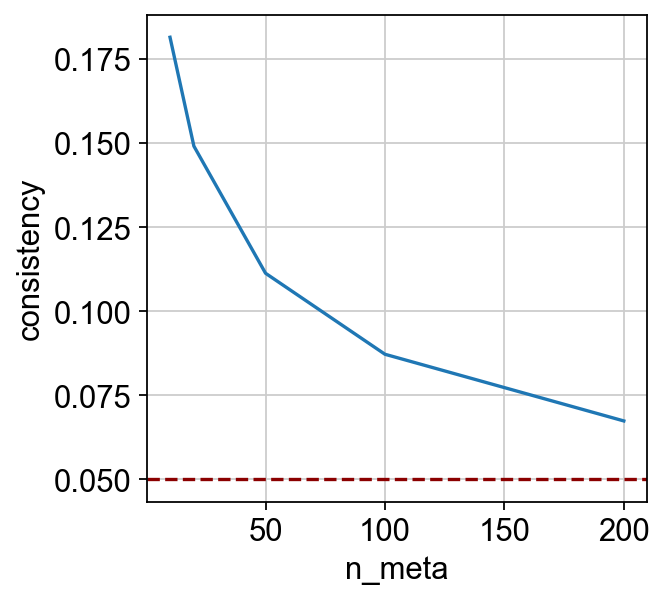

In [11]:
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")

In [12]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [13]:
combined = ad.concat([rna, atac])

/home/caozj/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


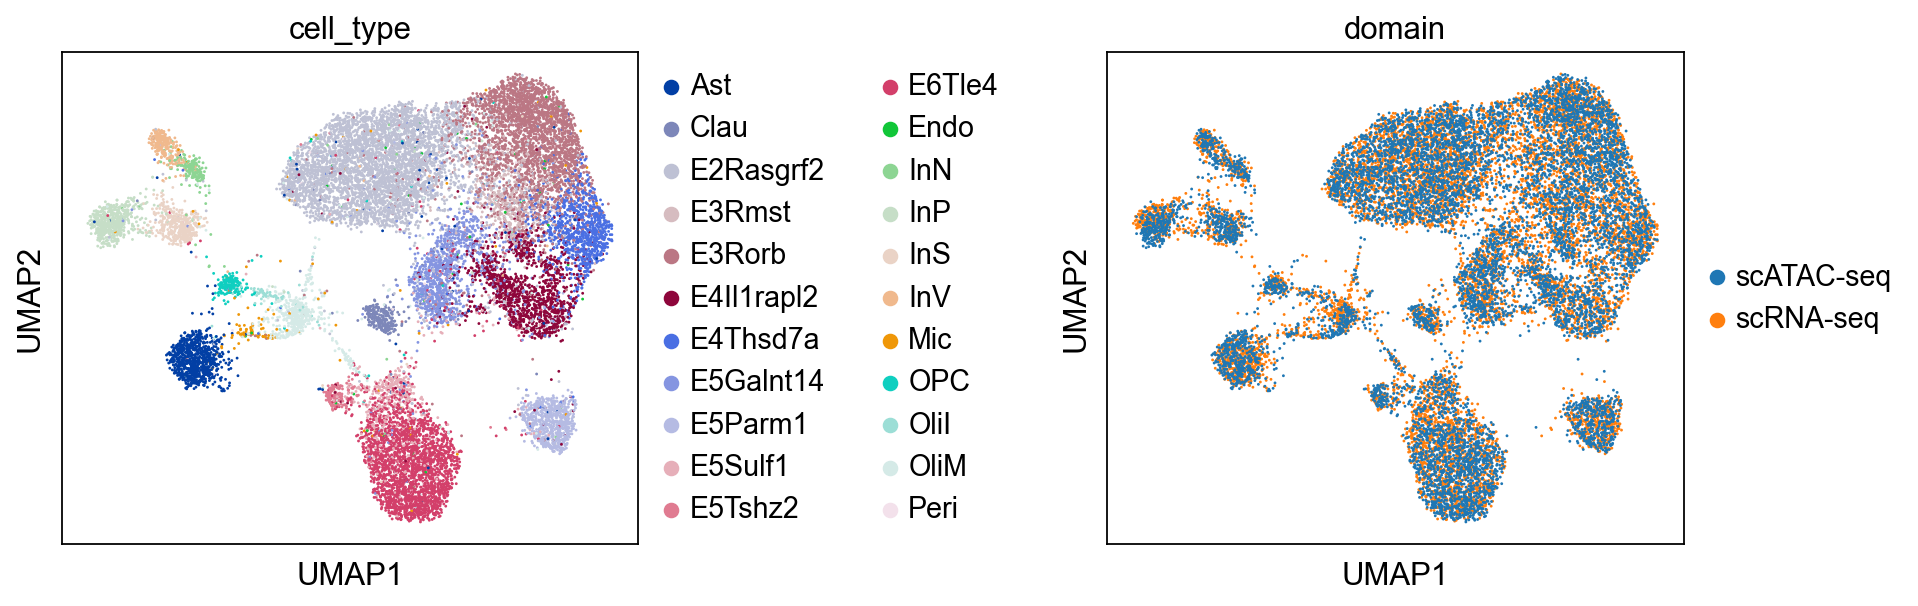

In [14]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["cell_type", "domain"], wspace=0.65)

In [15]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

,0,1,2,3,4
0610009B22Rik,-0.210796,0.003221,-0.001615,0.005132,0.001199
0610025J13Rik,0.063887,0.000348,0.000231,-0.000926,-0.003028
1110002J07Rik,-0.093619,-0.003181,-0.001749,0.005939,-0.011234
1110006O24Rik,-0.246847,-0.003636,0.000499,0.002448,-0.001151
1110020A21Rik,0.178541,0.001682,-0.000930,-0.001176,-0.013892


In [16]:
rna.varm["X_glue"] = feature_embeddings.reindex(rna.var_names).to_numpy()
atac.varm["X_glue"] = feature_embeddings.reindex(atac.var_names).to_numpy()